In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

### Generate synthetic data

In [2]:
# from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

# N = 10000
# M = 30
# K = 2 # binary problem (class labels: {1,2})
# NUM_SPLITS = 3

# Ds = [] # data
# Xs = [] # features
# Ls = [] # noisy labels
# Ys = [] # true labels
# for _ in range(NUM_SPLITS):
#     L, Y, _ = generate_single_task_unipolar(
#         N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
#         class_balance=[0.3, 0.7], seed=1)
    
#     X, D = gaussian_bags_of_words(Y, vocab1k)
    
#     Ls.append(L)
#     Ys.append(Y)
#     Ds.append(D)
#     Xs.append(X)

### Load YouTube source data

In [85]:
import os
import pandas as pd

# DATA_FILEPATH = os.environ['METALHOME'] + '/data/source_clicks.csv'
DATA_FILEPATH = os.environ['METALHOME'] + '/data/snorkel_527610_100Kposneg.csv'
# DATA_FILEPATH = os.environ['METALHOME'] + '/data/snorkel_527610_200Kuniform.csv'

L_data = pd.read_csv(DATA_FILEPATH).sample(200000).reset_index(drop=True)

N = L_data.shape[0]
print(f"Number of items: {N}")
L_data[:20]

Number of items: 200000


,event_id,spam_label_ids,organic_label_ids
0,1528134918075469:176053447:1729024668,NaN,1
1,1527753908712163:180190913:4161244819,NaN,0:6
2,1528661124630905:173143956:587620968,NaN,0:1
3,1528392695247858:175145107:4010031814,3,0
4,1527624368463530:177277711:2902498421,NaN,5
5,1528557347145388:169580813:1912926733,22,0
6,1528457711645241:181617475:3959473435,NaN,5:1
7,1528177151577718:174380307:1879191700,25:16:15,NaN
8,1528158189338257:176235670:470055836,15,0:2
9,1527628113059510:176235280:3640807248,NaN,0:6


In [86]:
%%time

from itertools import chain
from scipy.sparse import lil_matrix
import numpy as np

# YouTube
# DELIMITER = ','
# SPAM = 'spam_labels'
# HAM = 'ham_labels'

# GDN
DELIMITER = ':'
HAM = 'organic_label_ids'
SPAM = 'spam_label_ids'

# Get the pos/neg LF idxs, total number M
def split_LF_idxs(x):
    return map(int, x.split(DELIMITER)) if isinstance(x, str) else []

def get_LF_idxs(col):
    return set(chain.from_iterable([split_LF_idxs(x) for x in col]))

LF_pos_idxs = get_LF_idxs(L_data.iloc[:,1])
LF_neg_idxs = get_LF_idxs(L_data.iloc[:,2])
M = max(LF_pos_idxs | LF_neg_idxs) + 1

# Construct COO sparse matrix
L = lil_matrix((N, M))
for i, row in L_data.iterrows():
    for j in split_LF_idxs(row[SPAM]):
        L[i, j] = 1
    for j in split_LF_idxs(row[HAM]):
        L[i, j] = 2

# Convert to CSR matrix
L = L.tocsr().astype(np.int)
Ls = [L]

CPU times: user 17.7 s, sys: 163 ms, total: 17.8 s
Wall time: 17.9 s


In [87]:
Ls[0]

<200000x104 sparse matrix of type '<class 'numpy.int64'>'
	with 473260 stored elements in Compressed Sparse Row format>

### Apply LabelModel

Reaffirming seed=2
Reaffirming n_epochs=1000
Reaffirming lr=0.001
Reaffirming print_at=100
Reaffirming show_plots=True
Overwriting class_balance_init=[0.1, 0.9] to class_balance_init=[0.5, 0.5]
Overwriting l2=0.01 to l2=0
[Epoch 0] Loss: 4558.806476
[Epoch 100] Loss: 0.407929
[Epoch 200] Loss: 0.069186
[Epoch 300] Loss: 0.049870
[Epoch 400] Loss: 0.043712
[Epoch 500] Loss: 0.037236
[Epoch 600] Loss: 0.029741
[Epoch 700] Loss: 0.022175
[Epoch 800] Loss: 0.016114
[Epoch 900] Loss: 0.012316
[Epoch 999] Loss: 0.010356
Finished Training


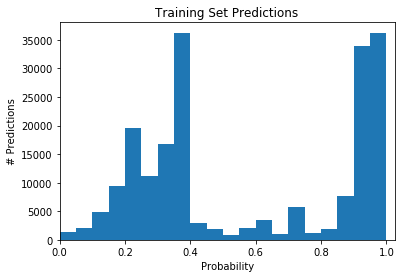

In [88]:
from metal.label_model import LabelModel

lm = LabelModel(seed=2)

y_pos = 0.5
lm.train(Ls[0], n_epochs=1000, lr=0.001, print_at=100, show_plots=True,
         class_balance_init=[y_pos, 1-y_pos], l2=0)

# Y_p = lm.score(Ls[1], Ys[1], metric='f1')

In [81]:
np.round(lm.O.numpy(), decimals=3)[3,:]

array([0.011, 0.015, 0.007, 0.055, 0.008, 0.006, 0.004, 0.002, 0.   ,
       0.001, 0.   , 0.006, 0.007, 0.006, 0.   , 0.   , 0.003, 0.009,
       0.   , 0.   , 0.003, 0.001, 0.   , 0.   , 0.002, 0.001, 0.   ,
       0.008, 0.006, 0.008, 0.004, 0.   , 0.   , 0.002, 0.002, 0.   ,
       0.   , 0.001, 0.   , 0.001, 0.   , 0.   , 0.001, 0.   , 0.001,
       0.   , 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   ])

In [82]:
np.round(lm.O.numpy(), decimals=3)[9,:]

array([0.   , 0.001, 0.   , 0.001, 0.   , 0.   , 0.001, 0.   , 0.   ,
       0.003, 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   ])

In [69]:
Y_p = lm.predict(Ls[0])

In [84]:
# sorted(
list(zip(
    lm._alphas().numpy(),
    lm._betas().numpy(),
    lm.polarity,
    LF_coverages(Ls[0]),
))
#, key=lambda x: x[2])

[(0.8876525945395399, 0.36021520760920017, 2, 0.60653),
 (0.95, 0.40021831596685253, 2, 0.82074),
 (0.95, 0.24603226667401712, 2, 0.44052),
 (0.05, 0.03179509996233794, 1, 0.05485),
 (0.95, 0.2970533314656644, 2, 0.51896),
 (0.48523894139717116, 0.07660882589840612, 1, 0.0471),
 (0.8346227006070391, 0.175808350051698, 1, 0.04469),
 (0.5230605620101347, 0.10454927986464005, 1, 0.05998),
 (0.95, -0.09627692423316815, 1, 0.001385),
 (0.95, -0.001139147899932651, 1, 0.0029),
 (0.5861170806976456, 0.2482152349209477, 2, 0.3157),
 (0.9288076534135256, 0.2152731242433592, 1, 0.030725),
 (0.8204738159139291, 0.11537660997714416, 1, 0.02708),
 (0.857042920332803, 0.21354010524914413, 1, 0.04845),
 (0.95, 0.10335777923816407, 1, 0.00428),
 (0.95, 0.14379882633442678, 1, 0.007485),
 (0.5668601604241083, 0.11860428301178988, 1, 0.059895),
 (0.5808376343862047, 0.04544684508871719, 1, 0.020105),
 (0.95, -0.053740960177290555, 1, 0.004915),
 (0.5076026044329436, 0.007038047307393928, 1, 0.00111),
 (

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lm._alphas().numpy())
plt.show()

In [ ]:
plt.hist(lm._betas().numpy())

### Random Search

In [ ]:
search_space = {
    'print_at': 200,
    'n_epochs': 1000, # a single constant value
    'l2': [0, 0.1, 0.01], # a list of discrete values
    'lr': {'range': [0.01, 0.0001], 'scale': 'log'}, # a range and scale to interpolate by
}

In [ ]:
from metal.tuner import ModelTuner

tuner = ModelTuner(LabelModel)
init_args = []
train_args = [Ls[0]]
model, best_config = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                  search_space, max_search=5, metric='accuracy')

### Metrics

Calculate metrics in one of two ways.

1. Use metric_score() and pass the metric name
3. The the specific metric's function (e.g., accuracy_score())

In [ ]:
from metal.metrics import metric_score, accuracy_score

metric_score(Ys[1], Y_p, 'accuracy')
accuracy_score(Ys[1], Y_p)

Built-in metrics include:

In [ ]:
metric_score(Ys[1], Y_p, 'accuracy')
metric_score(Ys[1], Y_p, 'coverage')
metric_score(Ys[1], Y_p, 'precision')
metric_score(Ys[1], Y_p, 'recall')
metric_score(Ys[1], Y_p, 'f1')
metric_score(Ys[1], Y_p, 'fbeta', beta=1.0)

### Confusion matrix

In [ ]:
from metal.analysis import confusion_matrix
confusion_matrix(Y_p, Ys[1])

In [ ]:
confusion_matrix(Y_p, Ys[1], normalize=True)

In [ ]:
mat = confusion_matrix(Y_p, Ys[1], pretty_print=True)

### Error analysis

In [ ]:
from metal.analysis import error_buckets

buckets = error_buckets(Y_p, Ys[1], Ds[1])
tp = buckets[1,1]
fp = buckets[1,2]

In [ ]:
fp[:1]

In [ ]:
tp[:3]

### Label matrix analysis

In [39]:
from metal.analysis import (
    item_coverage,
    item_overlap,
    item_conflict,
    LF_accuracies,
    LF_coverages,
    LF_overlaps,
    LF_conflicts,
)

In [40]:
item_coverage(Ls[0])

1.0

In [41]:
item_overlap(Ls[0])

0.93508

In [ ]:
item_conflict(Ls[0])

In [ ]:
# LF_accuracies(Ls[0], Ys[0])

In [56]:
sorted(LF_coverages(Ls[0]), reverse=True)

[0.82004,
 0.60584,
 0.51712,
 0.44312,
 0.31428,
 0.14928,
 0.05964,
 0.05932,
 0.05368,
 0.04838,
 0.04766,
 0.04564,
 0.03068,
 0.02724,
 0.02046,
 0.0173,
 0.01442,
 0.01156,
 0.01128,
 0.01122,
 0.00796,
 0.00788,
 0.00784,
 0.00782,
 0.00724,
 0.0056,
 0.00538,
 0.0053,
 0.00528,
 0.0048,
 0.00456,
 0.00438,
 0.00434,
 0.00404,
 0.004,
 0.00324,
 0.00276,
 0.0026,
 0.00258,
 0.0024,
 0.00212,
 0.00208,
 0.00188,
 0.00172,
 0.00164,
 0.00156,
 0.0015,
 0.00148,
 0.00144,
 0.0014,
 0.00138,
 0.00138,
 0.00132,
 0.00132,
 0.00128,
 0.0012,
 0.00106,
 0.00104,
 0.00102,
 0.001,
 0.00098,
 0.00098,
 0.0009,
 0.0009,
 0.00076,
 0.00072,
 0.00068,
 0.00062,
 0.0006,
 0.00058,
 0.00052,
 0.00052,
 0.0004,
 0.00038,
 0.00038,
 0.00036,
 0.00032,
 0.00032,
 0.0003,
 0.00026,
 0.00024,
 0.0002,
 0.0002,
 0.0002,
 0.00018,
 0.00016,
 0.00016,
 0.00012,
 0.00012,
 0.0001,
 0.0001,
 8e-05,
 6e-05,
 4e-05,
 2e-05,
 2e-05,
 2e-05,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
LF_overlaps(Ls[0])

In [ ]:
# LF_conflicts(Ls[0])

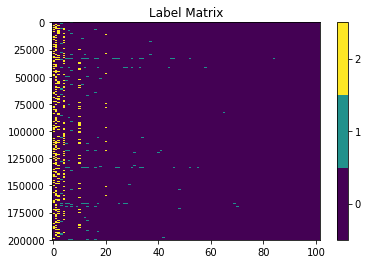

In [71]:
from metal.analysis import (
    view_label_matrix,
    view_overlaps,
    view_conflicts,
)

view_label_matrix(Ls[0])

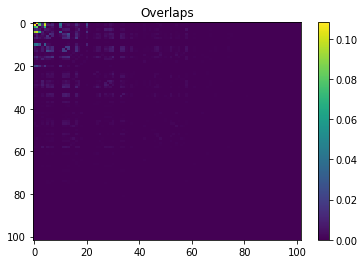

In [72]:
view_overlaps(Ls[0], normalize=True)

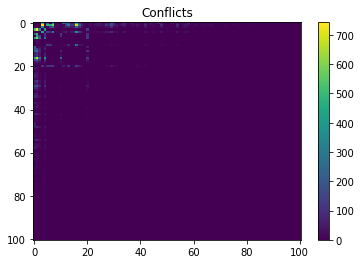

In [52]:
view_conflicts(Ls[0], normalize=False)